<a href="https://colab.research.google.com/github/Gaganpyla/Stock-Market-Trend-Prediction-System/blob/main/Stock%20Market%20Trend%20Prediction%20System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#!/usr/bin/env python
# coding: utf-8

# In[50]:


# import necessary libraries

get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web

def MovingAverageCrossStrategy(stock_symbol = 'ULTRACEMCO.NS', start_date = '2018-01-01', end_date = '2020-01-01',
                               short_window = 20, long_window = 50, moving_avg = 'SMA', display_table = True):
    '''
    The function takes the stock symbol, time-duration of analysis,
    look-back periods and the moving-average type(SMA or EMA) as input
    and returns the respective MA Crossover chart along with the buy/sell signals for the given period.
    '''
    # stock_symbol - (str)stock ticker as on Yahoo finance. Eg: 'ULTRACEMCO.NS'
    # start_date - (str)start analysis from this date (format: 'YYYY-MM-DD') Eg: '2018-01-01'
    # end_date - (str)end analysis on this date (format: 'YYYY-MM-DD') Eg: '2020-01-01'
    # short_window - (int)lookback period for short-term moving average. Eg: 5, 10, 20
    # long_window - (int)lookback period for long-term moving average. Eg: 50, 100, 200
    # moving_avg - (str)the type of moving average to use ('SMA' or 'EMA')
    # display_table - (bool)whether to display the date and price table at buy/sell positions(True/False)

    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    start = datetime.datetime(*map(int, start_date.split('-')))
    end = datetime.datetime(*map(int, end_date.split('-')))
    stock_df = web.DataReader(stock_symbol, 'yahoo', start = start, end = end)['Close']
    stock_df = pd.DataFrame(stock_df) # convert Series object to dataframe
    stock_df.columns = {'Close Price'} # assign new colun name
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows

    # column names for long and short moving average columns
    short_window_col = str(short_window) + '_' + moving_avg
    long_window_col = str(long_window) + '_' + moving_avg

    if moving_avg == 'SMA':
        # Create a short simple moving average column
        stock_df[short_window_col] = stock_df['Close Price'].rolling(window = short_window, min_periods = 1).mean()

        # Create a long simple moving average column
        stock_df[long_window_col] = stock_df['Close Price'].rolling(window = long_window, min_periods = 1).mean()

    elif moving_avg == 'EMA':
        # Create short exponential moving average column
        stock_df[short_window_col] = stock_df['Close Price'].ewm(span = short_window, adjust = False).mean()

        # Create a long exponential moving average column
        stock_df[long_window_col] = stock_df['Close Price'].ewm(span = long_window, adjust = False).mean()

    # create a new column 'Signal' such that if faster moving average is greater than slower moving average
    # then set Signal as 1 else 0.
    stock_df['Signal'] = 0.0
    stock_df['Signal'] = np.where(stock_df[short_window_col] > stock_df[long_window_col], 1.0, 0.0)

    # create a new column 'Position' which is a day-to-day difference of the 'Signal' column.
    stock_df['Position'] = stock_df['Signal'].diff()

    # plot close price, short-term and long-term moving averages
    plt.figure(figsize = (20,10))
    plt.tick_params(axis = 'both', labelsize = 14)
    stock_df['Close Price'].plot(color = 'k', lw = 1, label = 'Close Price')
    stock_df[short_window_col].plot(color = 'b', lw = 1, label = short_window_col)
    stock_df[long_window_col].plot(color = 'g', lw = 1, label = long_window_col)

    # plot 'buy' signals
    plt.plot(stock_df[stock_df['Position'] == 1].index,
            stock_df[short_window_col][stock_df['Position'] == 1],
            '^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy')

    # plot 'sell' signals
    plt.plot(stock_df[stock_df['Position'] == -1].index,
            stock_df[short_window_col][stock_df['Position'] == -1],
            'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')
    plt.ylabel('Price in ₹', fontsize = 16 )
    plt.xlabel('Date', fontsize = 16 )
    plt.title(str(stock_symbol) + ' - ' + str(moving_avg) + ' Crossover', fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show()

    if display_table == True:
        df_pos = stock_df[(stock_df['Position'] == 1) | (stock_df['Position'] == -1)]
        df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x == 1 else 'Sell')
        print(tabulate(df_pos, headers = 'keys', tablefmt = 'psql'))


In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web

def MovingAverageCrossStrategy(stock_symbol = 'ULTRACEMCO.NS',
                               start_date = '2018-01-01',
                               end_date = '2020-01-01',
                               short_window = 20,
                               long_window = 50,
                               moving_avg = 'SMA',
                               display_table = True,
                               initial_capital = 1.0):
    """
    Enhanced MA crossover function:
      - fetches Close prices
      - computes short and long MA (SMA or EMA)
      - builds buy/sell signals based on crossover
      - backtests a simple position-taking strategy (long=1, short=0 -> we go long or flat)
      - computes evaluation metrics: Total Return, CAGR, Sharpe, Max Drawdown, Win Rate, Trade Count
      - plots price + MAs + buy/sell markers and equity curve
      - prints a friendly summary and (optionally) the buy/sell table

    Note: initial_capital is normalized to 1 for easy % returns.
    """

    # fetch data
    start = datetime.datetime(*map(int, start_date.split('-')))
    end = datetime.datetime(*map(int, end_date.split('-')))
    close_series = web.DataReader(stock_symbol, 'yahoo', start = start, end = end)['Close']
    stock_df = pd.DataFrame(close_series).dropna()
    stock_df.columns = ['Close Price']

    # prepare column names
    short_col = f"{short_window}_{moving_avg}"
    long_col = f"{long_window}_{moving_avg}"

    # moving averages
    if moving_avg.upper() == 'SMA':
        stock_df[short_col] = stock_df['Close Price'].rolling(window = short_window, min_periods = 1).mean()
        stock_df[long_col]  = stock_df['Close Price'].rolling(window = long_window, min_periods = 1).mean()
    elif moving_avg.upper() == 'EMA':
        stock_df[short_col] = stock_df['Close Price'].ewm(span = short_window, adjust = False).mean()
        stock_df[long_col]  = stock_df['Close Price'].ewm(span = long_window, adjust = False).mean()
    else:
        raise ValueError("moving_avg must be 'SMA' or 'EMA'")

    # signals: 1 when short > long, else 0 (flat)
    stock_df['Signal'] = np.where(stock_df[short_col] > stock_df[long_col], 1.0, 0.0)
    stock_df['Position'] = stock_df['Signal'].diff()  # 1 = buy, -1 = sell

    # daily returns and strategy returns
    stock_df['Market_Return'] = stock_df['Close Price'].pct_change().fillna(0)
    # We use previous day's signal as today's exposure (to avoid lookahead)
    stock_df['Strategy_Exposure'] = stock_df['Signal'].shift(1).fillna(0)
    stock_df['Strategy_Return'] = stock_df['Strategy_Exposure'] * stock_df['Market_Return']

    # equity curve (starting capital normalized)
    stock_df['Equity'] = (1 + stock_df['Strategy_Return']).cumprod() * initial_capital

    # ---- Evaluation metrics ----
    days = (stock_df.index[-1] - stock_df.index[0]).days
    trading_days = stock_df.shape[0]  # approx trading rows in the period

    total_return = stock_df['Equity'].iloc[-1] - initial_capital  # absolute (in capital units)
    total_return_pct = (stock_df['Equity'].iloc[-1] / initial_capital - 1) * 100

    # CAGR: (ending/start)^(1/years) - 1
    years = days / 365.25
    if years > 0:
        cagr = (stock_df['Equity'].iloc[-1] / initial_capital) ** (1 / years) - 1
    else:
        cagr = np.nan

    # Sharpe ratio (assume risk-free ~ 0). Use daily returns of the strategy and annualize by sqrt(252).
    mean_daily = stock_df['Strategy_Return'].mean()
    std_daily = stock_df['Strategy_Return'].std(ddof=0)
    if std_daily != 0:
        sharpe = (mean_daily / std_daily) * np.sqrt(252)
    else:
        sharpe = np.nan

    # Max Drawdown
    roll_max = stock_df['Equity'].cummax()
    drawdown = (stock_df['Equity'] - roll_max) / roll_max
    max_drawdown = drawdown.min()  # negative number (e.g., -0.25 means -25%)

    # Trade-level returns and Win Rate
    # We will pair buy (Position==1) with the next sell (Position==-1). If a buy happens but never sold, use end price.
    trades = []
    entry_price = None
    entry_index = None
    for idx, row in stock_df.iterrows():
        pos = row['Position']
        price = row['Close Price']
        if pos == 1.0:  # buy
            entry_price = price
            entry_index = idx
        elif pos == -1.0 and entry_price is not None:  # sell closing a trade
            exit_price = price
            trade_ret = (exit_price / entry_price) - 1.0
            trades.append({'entry_date': entry_index, 'exit_date': idx,
                           'entry_price': entry_price, 'exit_price': exit_price,
                           'return': trade_ret})
            entry_price = None
            entry_index = None

    # if still holding at the end, close at last price
    if entry_price is not None:
        exit_price = stock_df['Close Price'].iloc[-1]
        trade_ret = (exit_price / entry_price) - 1.0
        trades.append({'entry_date': entry_index, 'exit_date': stock_df.index[-1],
                       'entry_price': entry_price, 'exit_price': exit_price,
                       'return': trade_ret})

    trade_count = len(trades)
    if trade_count > 0:
        wins = sum(1 for t in trades if t['return'] > 0)
        win_rate = wins / trade_count
        avg_trade_return = np.mean([t['return'] for t in trades])
        profit_factor = (sum([t['return'] for t in trades if t['return'] > 0]) /
                         (abs(sum([t['return'] for t in trades if t['return'] < 0])) + 1e-9))
    else:
        win_rate = np.nan
        avg_trade_return = np.nan
        profit_factor = np.nan

    # ---- Print friendly summary ----
    print("\n=== Strategy Summary ===")
    print(f"Ticker: {stock_symbol}   Period: {start_date} -> {end_date}")
    print(f"MA Type: {moving_avg}   Short: {short_window}   Long: {long_window}\n")
    print(f"Total Return: {total_return_pct:.2f}%")
    print(f"CAGR (annualized): {cagr*100:.2f}%")
    print(f"Sharpe Ratio (annualized): {sharpe:.2f}")
    print(f"Max Drawdown: {max_drawdown*100:.2f}%")
    if trade_count >= 0:
        print(f"Number of Trades: {trade_count}")
        if not np.isnan(win_rate):
            print(f"Win Rate: {win_rate*100:.2f}%   Avg Trade Return: {avg_trade_return*100:.2f}%")
    print("=========================\n")

    # ---- Plots: Price + MAs and Equity Curve ----
    plt.figure(figsize=(16,8))
    ax = plt.gca()
    stock_df['Close Price'].plot(ax=ax, lw=1, label='Close Price')
    stock_df[short_col].plot(ax=ax, lw=1, label=short_col)
    stock_df[long_col].plot(ax=ax, lw=1, label=long_col)
    # buy markers
    buys = stock_df[stock_df['Position'] == 1.0]
    sells = stock_df[stock_df['Position'] == -1.0]
    plt.plot(buys.index, buys[short_col], '^', markersize=10, label='Buy', alpha=0.8)
    plt.plot(sells.index, sells[short_col], 'v', markersize=10, label='Sell', alpha=0.8)
    plt.title(f"{stock_symbol} - {moving_avg} Crossover")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12,5))
    stock_df['Equity'].plot(lw=1)
    plt.title("Strategy Equity Curve (normalized)")
    plt.ylabel("Equity (starting at {:.2f})".format(initial_capital))
    plt.grid(True)
    plt.show()

    # display buy/sell table if requested
    if display_table:
        df_pos = stock_df[(stock_df['Position'] == 1) | (stock_df['Position'] == -1)].copy()
        df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x == 1 else 'Sell')
        print("Buy/Sell events:")
        print(tabulate(df_pos[['Close Price','Position']], headers='keys', tablefmt='psql'))

    # return metrics and trades for further use
    metrics = {
        'total_return_pct': total_return_pct,
        'cagr': cagr,
        'sharpe': sharpe,
        'max_drawdown_pct': max_drawdown * 100,
        'trade_count': trade_count,
        'win_rate': win_rate,
        'avg_trade_return': avg_trade_return,
        'profit_factor': profit_factor
    }

    trades_df = pd.DataFrame(trades)
    return stock_df, metrics, trades_df

# Example usage:
# df, metrics, trades = MovingAverageCrossStrategy('RELIANCE.NS', '2018-01-01', '2023-01-01', 20, 50, 'SMA')


In [ ]:
!git clone https://github.com/pratiknabriya/Moving-Average-Crossover-Trading-Strategy-with-Python.git

Cloning into 'Moving-Average-Crossover-Trading-Strategy-with-Python'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 21 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 456.53 KiB | 1.86 MiB/s, done.
Resolving deltas: 100% (4/4), done.


[*********************100%***********************]  1 of 1 completed



=== Strategy Summary ===
Ticker: ULTRACEMCO.NS   Period: 2018-02-01 -> 2020-10-01
MA Type: EMA   Short: 20   Long: 50
Total Return: -7.50%
CAGR: -2.89%
Sharpe Ratio: -0.09
Max Drawdown: -23.74%
Number of Trades: 8
Win Rate: 25.00%   Avg Trade Return: -0.83%


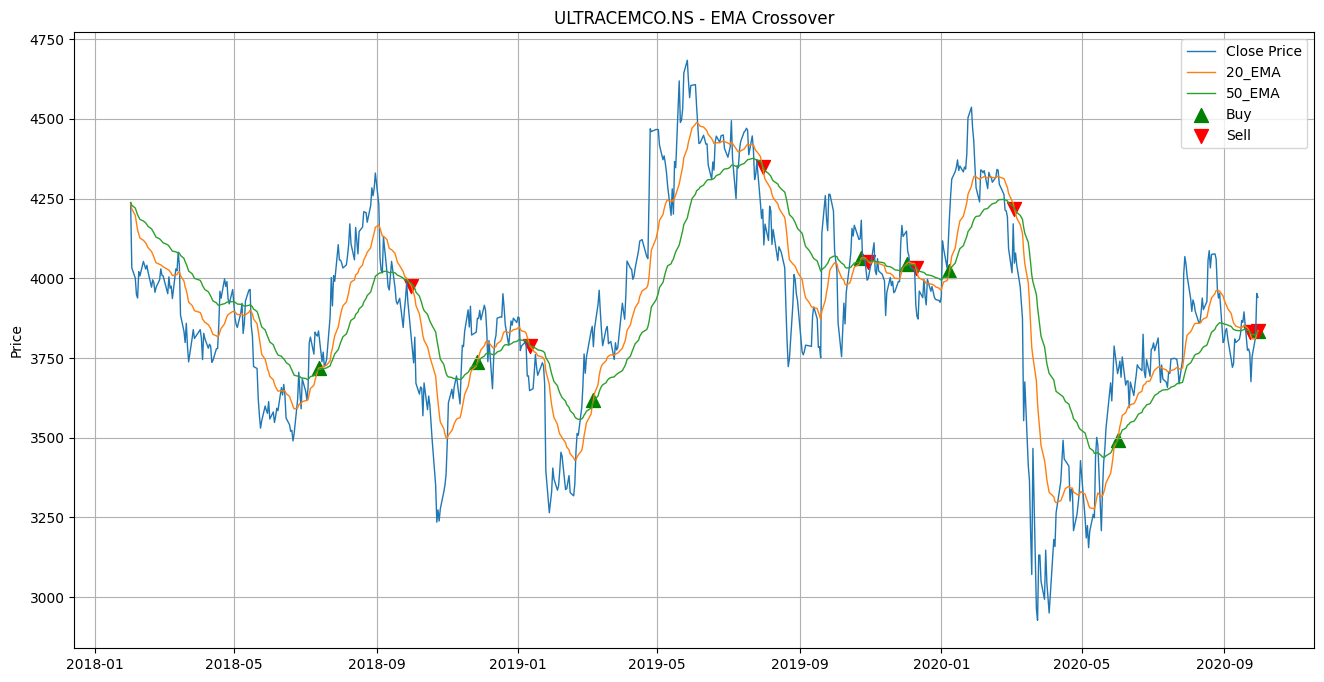

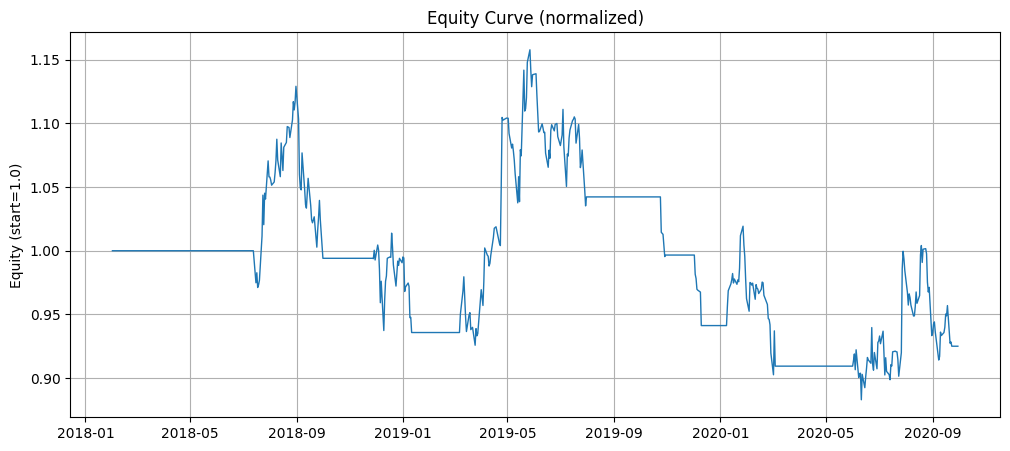

Buy/Sell Events:
+---------------------+------------------------------------+--------------------+
| Date                |   ('Close Price', 'ULTRACEMCO.NS') | ('Position', '')   |
|---------------------+------------------------------------+--------------------|
| 2018-07-13 00:00:00 |                            3834.73 | Buy                |
| 2018-10-01 00:00:00 |                            3811.95 | Sell               |
| 2018-11-27 00:00:00 |                            3874.64 | Buy                |
| 2019-01-11 00:00:00 |                            3647.48 | Sell               |
| 2019-03-07 00:00:00 |                            3785.44 | Buy                |
| 2019-07-31 00:00:00 |                            4216.19 | Sell               |
| 2019-10-24 00:00:00 |                            4181.9  | Buy                |
| 2019-10-30 00:00:00 |                            3998.73 | Sell               |
| 2019-12-02 00:00:00 |                            4147.66 | Buy                |

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from tabulate import tabulate

def MovingAverageCrossStrategy_YF(stock_symbol='ULTRACEMCO.NS',
                                   start_date='2018-01-01',
                                   end_date='2020-01-01',
                                   short_window=20,
                                   long_window=50,
                                   moving_avg='SMA',
                                   display_table=True,
                                   initial_capital=1.0):
    # Fetch data
    df = yf.download(stock_symbol, start=start_date, end=end_date)
    df = df[['Close']].rename(columns={'Close':'Close Price'})

    # Moving averages
    short_col = f"{short_window}_{moving_avg}"
    long_col = f"{long_window}_{moving_avg}"
    if moving_avg.upper() == 'SMA':
        df[short_col] = df['Close Price'].rolling(short_window, min_periods=1).mean()
        df[long_col] = df['Close Price'].rolling(long_window, min_periods=1).mean()
    elif moving_avg.upper() == 'EMA':
        df[short_col] = df['Close Price'].ewm(span=short_window, adjust=False).mean()
        df[long_col] = df['Close Price'].ewm(span=long_window, adjust=False).mean()
    else:
        raise ValueError("moving_avg must be 'SMA' or 'EMA'")

    # Signals
    df['Signal'] = (df[short_col] > df[long_col]).astype(float)
    df['Position'] = df['Signal'].diff().fillna(0)

    # Strategy returns
    df['Market_Return'] = df['Close Price'].pct_change().fillna(0)
    df['Strategy_Exposure'] = df['Signal'].shift(1).fillna(0)
    df['Strategy_Return'] = df['Strategy_Exposure'] * df['Market_Return']
    df['Equity'] = (1 + df['Strategy_Return']).cumprod() * initial_capital

    # Vectorized trade calculation
    buy_idx = df.index[df['Position'] == 1]
    sell_idx = df.index[df['Position'] == -1]

    # Align buy/sell signals
    if len(sell_idx) > 0 and len(buy_idx) > 0 and sell_idx[0] < buy_idx[0]:
        sell_idx = sell_idx[1:]
    if len(buy_idx) > len(sell_idx):
        sell_idx = sell_idx.append(pd.Index([df.index[-1]]))

    trades_df = pd.DataFrame({
        'entry_date': buy_idx,
        'exit_date': sell_idx
    })
    trades_df['entry_price'] = df.loc[trades_df['entry_date'], 'Close Price'].values
    trades_df['exit_price'] = df.loc[trades_df['exit_date'], 'Close Price'].values
    trades_df['return'] = (trades_df['exit_price'] / trades_df['entry_price']) - 1

    # Metrics
    trade_count = len(trades_df)
    wins = (trades_df['return'] > 0).sum() if trade_count > 0 else 0
    win_rate = wins / trade_count if trade_count > 0 else np.nan
    avg_trade_return = trades_df['return'].mean() if trade_count > 0 else np.nan
    profit_factor = (trades_df.loc[trades_df['return'] > 0, 'return'].sum() /
                     (abs(trades_df.loc[trades_df['return'] < 0, 'return'].sum()) + 1e-9)
                     if trade_count > 0 else np.nan)

    days = (df.index[-1] - df.index[0]).days
    total_return_pct = (df['Equity'].iloc[-1] / initial_capital - 1) * 100
    years = days / 365.25
    cagr = (df['Equity'].iloc[-1] / initial_capital) ** (1 / years) - 1 if years > 0 else np.nan
    mean_daily = df['Strategy_Return'].mean()
    std_daily = df['Strategy_Return'].std(ddof=0)
    sharpe = (mean_daily / std_daily) * np.sqrt(252) if std_daily != 0 else np.nan
    max_drawdown = ((df['Equity'] - df['Equity'].cummax()) / df['Equity'].cummax()).min()

    # Print summary
    print("\n=== Strategy Summary ===")
    print(f"Ticker: {stock_symbol}   Period: {start_date} -> {end_date}")
    print(f"MA Type: {moving_avg}   Short: {short_window}   Long: {long_window}")
    print(f"Total Return: {total_return_pct:.2f}%")
    print(f"CAGR: {cagr*100:.2f}%")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: {max_drawdown*100:.2f}%")
    print(f"Number of Trades: {trade_count}")
    if not np.isnan(win_rate):
        print(f"Win Rate: {win_rate*100:.2f}%   Avg Trade Return: {avg_trade_return*100:.2f}%")
    print("=========================")

    # Plot price and MA with buy/sell markers
    plt.figure(figsize=(16,8))
    plt.plot(df['Close Price'], label='Close Price', lw=1)
    plt.plot(df[short_col], label=short_col, lw=1)
    plt.plot(df[long_col], label=long_col, lw=1)
    plt.scatter(buy_idx, df.loc[buy_idx, short_col], marker='^', color='g', s=100, label='Buy')
    plt.scatter(sell_idx, df.loc[sell_idx, short_col], marker='v', color='r', s=100, label='Sell')
    plt.title(f"{stock_symbol} - {moving_avg} Crossover")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot equity curve
    plt.figure(figsize=(12,5))
    plt.plot(df['Equity'], lw=1)
    plt.title("Equity Curve (normalized)")
    plt.ylabel(f"Equity (start={initial_capital})")
    plt.grid(True)
    plt.show()

    # Buy/Sell Table
    if display_table:
        df_pos = df[df['Position'] != 0].copy()
        df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x==1 else 'Sell')
        print("Buy/Sell Events:")
        print(tabulate(df_pos[['Close Price','Position']], headers='keys', tablefmt='psql'))

    metrics = {
        'total_return_pct': total_return_pct,
        'cagr': cagr,
        'sharpe': sharpe,
        'max_drawdown_pct': max_drawdown*100,
        'trade_count': trade_count,
        'win_rate': win_rate,
        'avg_trade_return': avg_trade_return,
        'profit_factor': profit_factor
    }

    return df, metrics, trades_df
df, metrics, trades = MovingAverageCrossStrategy_YF('ULTRACEMCO.NS', '2018-02-01', '2020-10-01', 20, 50, 'EMA')


[*********************100%***********************]  1 of 1 completed


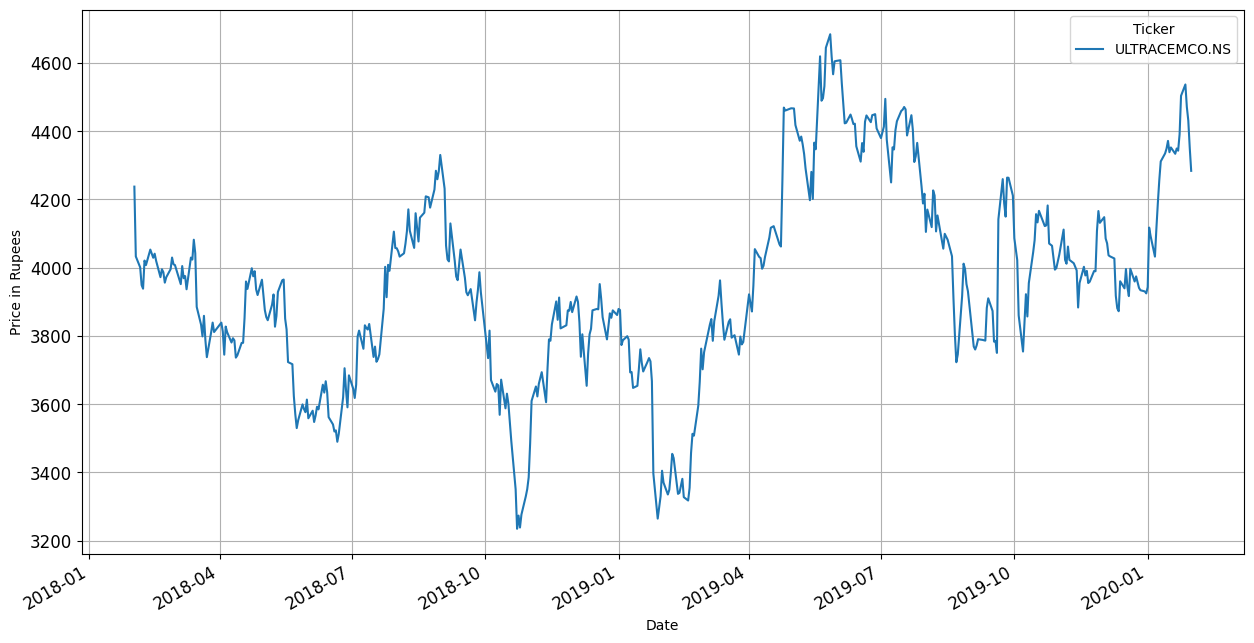

<Figure size 2000x1000 with 0 Axes>

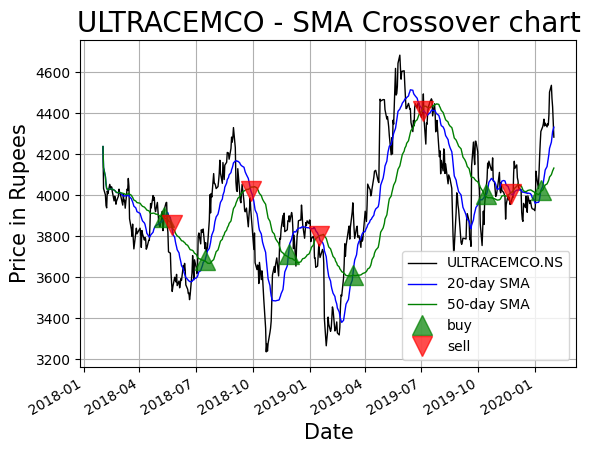

<Figure size 2000x1000 with 0 Axes>

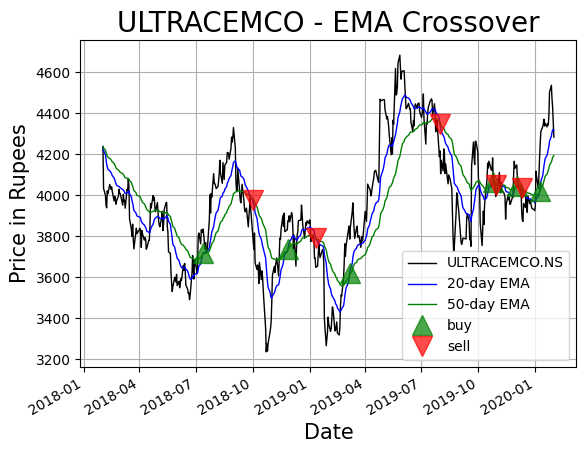

+---------------------+------------------------------------+------------------+------------------+------------------+--------------------+------------------+------------------+
| Date                |   ('Close Price', 'ULTRACEMCO.NS') |   ('20_SMA', '') |   ('50_SMA', '') |   ('Signal', '') | ('Position', '')   |   ('20_EMA', '') |   ('50_EMA', '') |
|---------------------+------------------------------------+------------------+------------------+------------------+--------------------+------------------+------------------|
| 2018-07-13 00:00:00 |                            3834.73 |          3671.46 |          3682.54 |                1 | Buy                |          3718.01 |          3713.91 |
| 2018-10-01 00:00:00 |                            3811.95 |          3998.18 |          4039.91 |                0 | Sell               |          3976.33 |          3984.13 |
| 2018-11-27 00:00:00 |                            3874.64 |          3684.69 |          3698.76 |                1

In [ ]:
# Import libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Fetch data using yfinance
start = '2018-02-01'
end = '2020-02-01'

ultratech_df = yf.download('ULTRACEMCO.NS', start=start, end=end)

# Keep only Close price and rename column
ultratech_df = ultratech_df[['Close']]
ultratech_df.rename(columns={'Close': 'Close Price'}, inplace=True)

# Plot Close Price
ultratech_df['Close Price'].plot(figsize=(15, 8), fontsize=12)
plt.grid()
plt.ylabel('Price in Rupees')
plt.show()

# Calculate Moving Averages
ultratech_df['20_SMA'] = ultratech_df['Close Price'].rolling(window=20, min_periods=1).mean()
ultratech_df['50_SMA'] = ultratech_df['Close Price'].rolling(window=50, min_periods=1).mean()

# SMA Crossover Signals
ultratech_df['Signal'] = np.where(ultratech_df['20_SMA'] > ultratech_df['50_SMA'], 1.0, 0.0)
ultratech_df['Position'] = ultratech_df['Signal'].diff()

# Plot SMA Crossover
plt.figure(figsize=(20,10))
ultratech_df['Close Price'].plot(color='k', lw=1, label='Close Price')
ultratech_df['20_SMA'].plot(color='b', lw=1, label='20-day SMA')
ultratech_df['50_SMA'].plot(color='g', lw=1, label='50-day SMA')

plt.plot(ultratech_df[ultratech_df['Position'] == 1].index,
         ultratech_df['20_SMA'][ultratech_df['Position'] == 1],
         '^', markersize=15, color='g', alpha=0.7, label='buy')

plt.plot(ultratech_df[ultratech_df['Position'] == -1].index,
         ultratech_df['20_SMA'][ultratech_df['Position'] == -1],
         'v', markersize=15, color='r', alpha=0.7, label='sell')

plt.ylabel('Price in Rupees', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.title('ULTRACEMCO - SMA Crossover chart', fontsize=20)
plt.legend()
plt.grid()
plt.show()

# EMA Crossover
ultratech_df['20_EMA'] = ultratech_df['Close Price'].ewm(span=20, adjust=False).mean()
ultratech_df['50_EMA'] = ultratech_df['Close Price'].ewm(span=50, adjust=False).mean()
ultratech_df['Signal'] = np.where(ultratech_df['20_EMA'] > ultratech_df['50_EMA'], 1.0, 0.0)
ultratech_df['Position'] = ultratech_df['Signal'].diff()

# Plot EMA Crossover
plt.figure(figsize=(20,10))
ultratech_df['Close Price'].plot(color='k', lw=1, label='Close Price')
ultratech_df['20_EMA'].plot(color='b', lw=1, label='20-day EMA')
ultratech_df['50_EMA'].plot(color='g', lw=1, label='50-day EMA')

plt.plot(ultratech_df[ultratech_df['Position'] == 1].index,
         ultratech_df['20_EMA'][ultratech_df['Position'] == 1],
         '^', markersize=15, color='g', alpha=0.7, label='buy')

plt.plot(ultratech_df[ultratech_df['Position'] == -1].index,
         ultratech_df['20_EMA'][ultratech_df['Position'] == -1],
         'v', markersize=15, color='r', alpha=0.7, label='sell')

plt.ylabel('Price in Rupees', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.title('ULTRACEMCO - EMA Crossover', fontsize=20)
plt.legend()
plt.grid()
plt.show()

# Tabulate buy/sell signals
from tabulate import tabulate

df_new = ultratech_df[(ultratech_df['Position'] == 1) | (ultratech_df['Position'] == -1)]
df_new['Position'] = df_new['Position'].apply(lambda x: 'Buy' if x == 1 else 'Sell')
print(tabulate(df_new, headers='keys', tablefmt='psql'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



=== SMA Evaluation Results ===
   short_window  long_window  total_return_pct      cagr    sharpe  \
1            30           50         15.051304  0.072774  0.519251   
0            20           50          0.394018  0.001972  0.092497   
2            40           50         -3.221032 -0.016270 -0.031760   
3            20          100         -4.833070 -0.024514 -0.091158   
6            50          100        -21.638862 -0.115004 -0.618807   
4            30          100        -23.829730 -0.127489 -0.764988   
5            40          100        -28.234542 -0.153144 -0.926718   

   max_drawdown_pct  trade_count  win_rate  avg_trade_return  profit_factor  
1        -19.315834            6  0.666667          0.025160       4.594176  
0        -16.765027            6  0.333333          0.002714       1.109998  
2        -20.450699            7  0.285714         -0.002926       0.877068  
3        -19.167220            4  0.500000         -0.010691       0.642394  
6        -31.0349

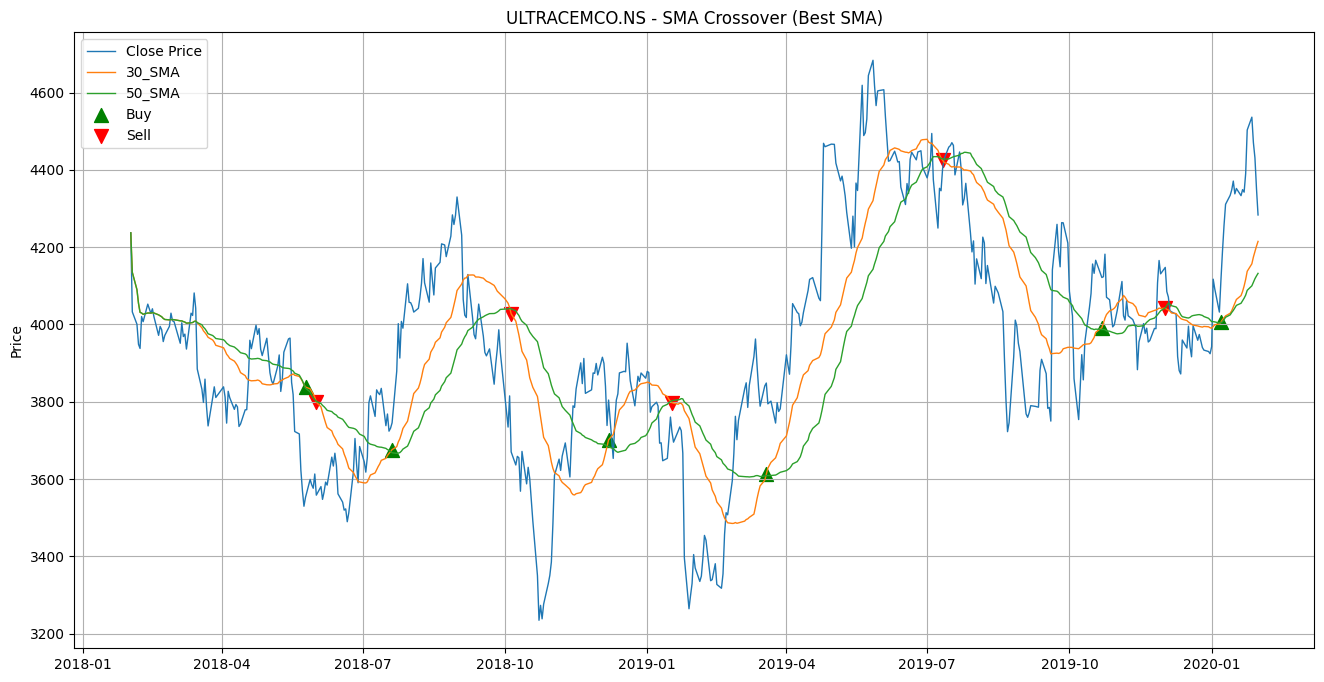

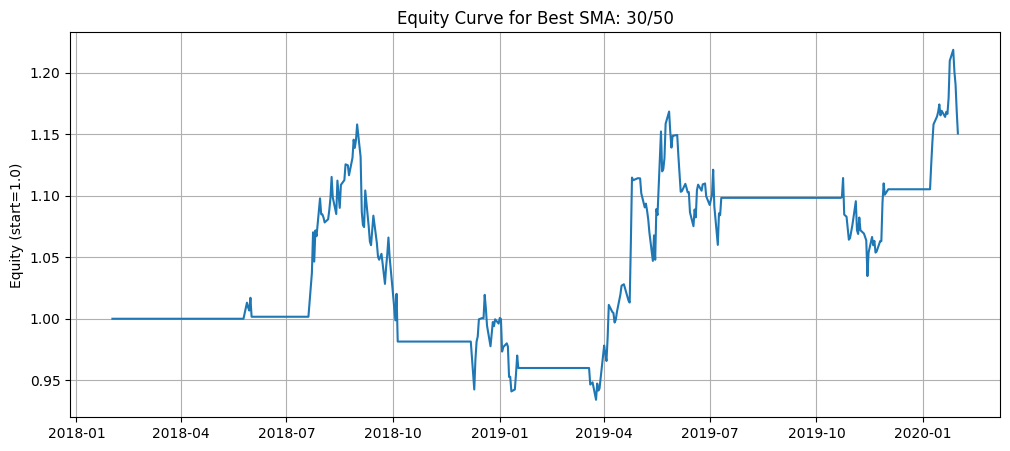

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from tabulate import tabulate

# ---------------- MA Strategy Function ----------------
def MovingAverageCrossStrategy_YF(stock_symbol='ULTRACEMCO.NS',
                                   start_date='2018-01-01',
                                   end_date='2020-01-01',
                                   short_window=20,
                                   long_window=50,
                                   moving_avg='SMA',
                                   display_table=True,
                                   initial_capital=1.0):
    # Fetch data
    df = yf.download(stock_symbol, start=start_date, end=end_date)
    df = df[['Close']].rename(columns={'Close':'Close Price'})

    # Moving averages
    short_col = f"{short_window}_{moving_avg}"
    long_col = f"{long_window}_{moving_avg}"
    if moving_avg.upper() == 'SMA':
        df[short_col] = df['Close Price'].rolling(short_window, min_periods=1).mean()
        df[long_col] = df['Close Price'].rolling(long_window, min_periods=1).mean()
    elif moving_avg.upper() == 'EMA':
        df[short_col] = df['Close Price'].ewm(span=short_window, adjust=False).mean()
        df[long_col] = df['Close Price'].ewm(span=long_window, adjust=False).mean()
    else:
        raise ValueError("moving_avg must be 'SMA' or 'EMA'")

    # Signals
    df['Signal'] = (df[short_col] > df[long_col]).astype(float)
    df['Position'] = df['Signal'].diff().fillna(0)

    # Strategy returns
    df['Market_Return'] = df['Close Price'].pct_change().fillna(0)
    df['Strategy_Exposure'] = df['Signal'].shift(1).fillna(0)
    df['Strategy_Return'] = df['Strategy_Exposure'] * df['Market_Return']
    df['Equity'] = (1 + df['Strategy_Return']).cumprod() * initial_capital

    # Vectorized trade calculation
    buy_idx = df.index[df['Position'] == 1]
    sell_idx = df.index[df['Position'] == -1]

    # Align buy/sell signals
    if len(sell_idx) > 0 and len(buy_idx) > 0 and sell_idx[0] < buy_idx[0]:
        sell_idx = sell_idx[1:]
    if len(buy_idx) > len(sell_idx):
        sell_idx = sell_idx.append(pd.Index([df.index[-1]]))

    trades_df = pd.DataFrame({
        'entry_date': buy_idx,
        'exit_date': sell_idx
    })
    trades_df['entry_price'] = df.loc[trades_df['entry_date'], 'Close Price'].values
    trades_df['exit_price'] = df.loc[trades_df['exit_date'], 'Close Price'].values
    trades_df['return'] = (trades_df['exit_price'] / trades_df['entry_price']) - 1

    # Metrics
    trade_count = len(trades_df)
    wins = (trades_df['return'] > 0).sum() if trade_count > 0 else 0
    win_rate = wins / trade_count if trade_count > 0 else np.nan
    avg_trade_return = trades_df['return'].mean() if trade_count > 0 else np.nan
    profit_factor = (trades_df.loc[trades_df['return'] > 0, 'return'].sum() /
                     (abs(trades_df.loc[trades_df['return'] < 0, 'return'].sum()) + 1e-9)
                     if trade_count > 0 else np.nan)

    days = (df.index[-1] - df.index[0]).days
    total_return_pct = (df['Equity'].iloc[-1] / initial_capital - 1) * 100
    years = days / 365.25
    cagr = (df['Equity'].iloc[-1] / initial_capital) ** (1 / years) - 1 if years > 0 else np.nan
    mean_daily = df['Strategy_Return'].mean()
    std_daily = df['Strategy_Return'].std(ddof=0)
    sharpe = (mean_daily / std_daily) * np.sqrt(252) if std_daily != 0 else np.nan
    max_drawdown = ((df['Equity'] - df['Equity'].cummax()) / df['Equity'].cummax()).min()

    metrics = {
        'total_return_pct': total_return_pct,
        'cagr': cagr,
        'sharpe': sharpe,
        'max_drawdown_pct': max_drawdown*100,
        'trade_count': trade_count,
        'win_rate': win_rate,
        'avg_trade_return': avg_trade_return,
        'profit_factor': profit_factor
    }

    return df, metrics, trades_df

# ---------------- Evaluate Multiple SMA Parameters ----------------
def EvaluateSMAParameters(stock_symbol='ULTRACEMCO.NS',
                          start_date='2018-02-01',
                          end_date='2020-02-01',
                          short_windows=[20,30,40,50],
                          long_windows=[50,100],
                          moving_avg='SMA',
                          initial_capital=1.0):
    """
    Evaluate multiple short and long SMA lengths.
    Returns DataFrame of metrics and best combination based on Sharpe Ratio.
    """
    results = []

    for long_w in long_windows:
        for short_w in short_windows:
            if short_w >= long_w:
                continue  # Short MA must be less than Long MA
            _, metrics, _ = MovingAverageCrossStrategy_YF(
                stock_symbol=stock_symbol,
                start_date=start_date,
                end_date=end_date,
                short_window=short_w,
                long_window=long_w,
                moving_avg=moving_avg,
                display_table=False,
                initial_capital=initial_capital
            )
            metrics['short_window'] = short_w
            metrics['long_window'] = long_w
            results.append(metrics)

    metrics_df = pd.DataFrame(results)
    metrics_df.sort_values(by='sharpe', ascending=False, inplace=True)

    print("\n=== SMA Evaluation Results ===")
    print(metrics_df[['short_window','long_window','total_return_pct','cagr','sharpe','max_drawdown_pct','trade_count','win_rate','avg_trade_return','profit_factor']])

    best = metrics_df.iloc[0]
    print("\n=== Best SMA Combination (Based on Sharpe Ratio) ===")
    print(f"Short SMA: {best['short_window']}, Long SMA: {best['long_window']}")
    print(f"Sharpe Ratio: {best['sharpe']:.2f}, Total Return: {best['total_return_pct']:.2f}%")

    # Run strategy again for best SMA to get full data for plotting
    df_best, _, _ = MovingAverageCrossStrategy_YF(
        stock_symbol=stock_symbol,
        start_date=start_date,
        end_date=end_date,
        short_window=int(best['short_window']),
        long_window=int(best['long_window']),
        moving_avg=moving_avg,
        display_table=True,
        initial_capital=initial_capital
    )

    # Plot price, MAs, and buy/sell signals for best combination
    short_col_best = f"{int(best['short_window'])}_{moving_avg}"
    long_col_best = f"{int(best['long_window'])}_{moving_avg}"

    buy_idx = df_best.index[df_best['Position'] == 1]
    sell_idx = df_best.index[df_best['Position'] == -1]

    plt.figure(figsize=(16,8))
    plt.plot(df_best['Close Price'], label='Close Price', lw=1)
    plt.plot(df_best[short_col_best], label=short_col_best, lw=1)
    plt.plot(df_best[long_col_best], label=long_col_best, lw=1)
    plt.scatter(buy_idx, df_best.loc[buy_idx, short_col_best], marker='^', color='g', s=100, label='Buy')
    plt.scatter(sell_idx, df_best.loc[sell_idx, short_col_best], marker='v', color='r', s=100, label='Sell')
    plt.title(f"{stock_symbol} - {moving_avg} Crossover (Best SMA)")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Equity curve for best combination
    plt.figure(figsize=(12,5))
    plt.plot(df_best['Equity'], lw=1.5)
    plt.title(f"Equity Curve for Best SMA: {int(best['short_window'])}/{int(best['long_window'])}")
    plt.ylabel(f"Equity (start={initial_capital})")
    plt.grid(True)
    plt.show()

    return metrics_df, best

# ---------------- Example Usage ----------------
metrics_df, best_sma = EvaluateSMAParameters(
    stock_symbol='ULTRACEMCO.NS',
    start_date='2018-02-01',
    end_date='2020-02-01',
    short_windows=[20,30,40,50],
    long_windows=[50,100],
    moving_avg='SMA'
)
